In [3]:
import lpfet
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import essentials
import seaborn as sns
import matplotlib.colors as mcolors

import importlib
importlib.reload(lpfet)

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 6 site **chain** with constant potential difference between neighbouring atoms  
```
a-b-c-d-e-f
```
All depends on variable i - element of array x that sets potentials:


| site | external potential | 
| --- | --- |
| a | -2.5i | 
| b | -1.5i |
| c | -0.5i |
| d | +0.5i |
| e | +1.5i |
| f | +2.5i |

In [4]:
from importlib import reload
reload(lpfet)

<module 'lpfet' from '/mnt/c/Users/tinc9/Documents/CNRS-offline/quantum_main_project/LPFET/lpfet.py'>

In [7]:
lpfet.COMPENSATION_1_RATIO = 0.25
x = np.linspace(0.05, 2.1, 20)
# x = np.arange(0.01, 0.1, 0.005)
U_param = 3
n_electron = 4
n_sites = 6
name = 'chain1'
mol1 = lpfet.Molecule(n_sites, n_electron, name)
mol_full = lpfet.class_Quant_NBody.QuantNBody(n_sites, n_electron)
mol_full.build_operator_a_dagger_a()
y = []
y_simple = []
y_ref = []
energy_ref = []
energy = []
first = True
correction_dict_list = []
for i in x:
    if not first:
        mol1.clear_object(name)
    first = False
    print(f'{i:.1f}, {i/max(x)*100:.1f}%: ', end=' ')
    pmv = i
    
    nodes_dict = dict()
    edges_dict = dict()
    eq_list = []
    for j in range(6):
        nodes_dict[j] = {'v': (j - 2.5) * i, 'U': U_param}
        if j != 5:
            edges_dict[(j, j+1)] = 1
        eq_list.append([j])
    t, v_ext, u = lpfet.generate_from_graph(nodes_dict, edges_dict)
    mol1.add_parameters(u, t, v_ext, eq_list)
    mol1.self_consistent_loop(num_iter=30, tolerance=1E-6, oscillation_compensation=1)
    # mol1.optimize_solution(5, 0.2)
    mol1.calculate_energy(True)
    correction_dict_list.append(mol1.oscillation_correction_dict)
    y.append(mol1.density_progress)
    y_simple.append(mol1.n_ks)
    y_ab, mol_fci, energy_ref_i =mol1.compare_densities_FCI(pass_object=mol_full)
    y_ref.append(y_ab.diagonal())
    
    energy.append(mol1.energy_contributions)
    energy_ref.append(energy_ref_i)

for i in range(len(y)):
    y[i] = np.array(y[i], dtype=float)
y_ref = np.array(y_ref)
y_simple = np.array(y_simple) 

E = np.array(energy, dtype=[('tot', float), ('kin', float), ('v_ext', float), ('u', float)])
E_ref = np.array(energy_ref, dtype=[('tot', float), ('kin', float), ('v_ext', float), ('u', float)])


	 ====  The matrix form of a^a is built  ====

	 ====  The matrix form of a^a is built  ====
0.1, 2.4%:  Loop 0, Loop 1, 0.53->0.76->0.71!=0.57, 1.34->0.81->0.94!=1.31, 0.74->0.82->0.80!=0.72, 0.86->0.73->0.77!=0.90, 1.18->0.84->0.90!=1.10, 0.35->0.73->0.63!=0.36, Loop 2, Loop 3, 0.94->1.18->1.12!=0.93, 0.80->0.76->0.77!=0.80, 0.77->0.85->0.82!=0.74, 0.90->1.06->1.03!=0.94, 0.63->0.42->0.47!=0.64, Loop 4, 0.60->0.67->0.66!=0.61, Loop 5, 0.67->0.66->0.66!=0.68, 1.12->1.00->1.03!=1.12, 0.77->0.81->0.79!=0.74, 0.82->0.77->0.79!=0.85, 0.47->0.58->0.55!=0.44, Loop 6, 0.66->0.66->0.66!=0.66, Loop 7, 1.03->1.08->1.07!=1.02, 0.79->0.76->0.77!=0.80, 0.79->0.83->0.81!=0.77, 0.99->0.98->0.99!=1.00, 0.55->0.48->0.50!=0.56, Loop 8, 0.66->0.62->0.63!=0.68, 0.98->0.99->0.99!=0.98, Loop 9, 1.07->1.03->1.04!=1.06, 0.81->0.79->0.80!=0.81, 0.50->0.52->0.51!=0.50, Loop 10, 0.63->0.66->0.65!=0.63, 0.99->0.98->0.98!=0.99, 0.52->0.51->0.51!=0.52, Loop 11, Loop 12, 0.65->0.65->0.65!=0.65, 0.98->0.99->0.99!=0

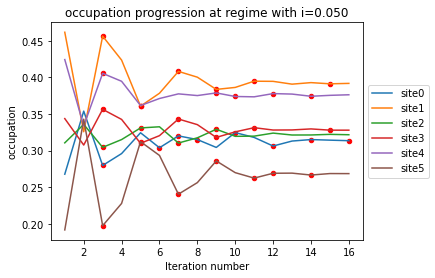

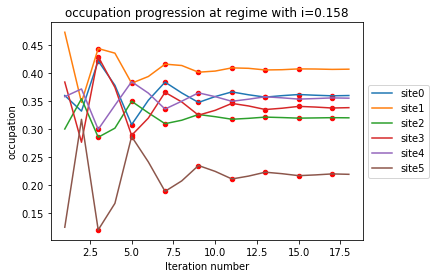

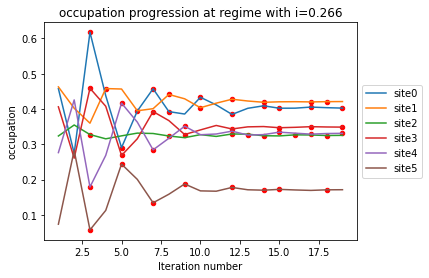

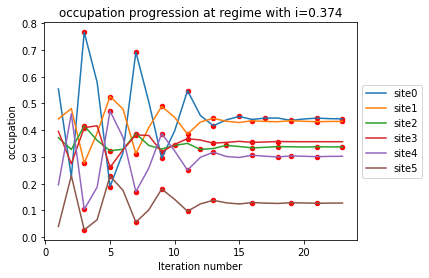

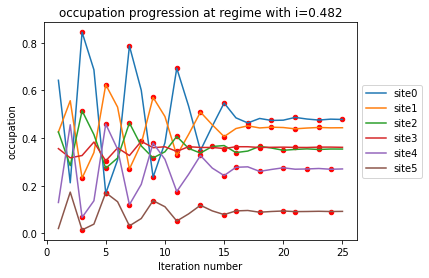

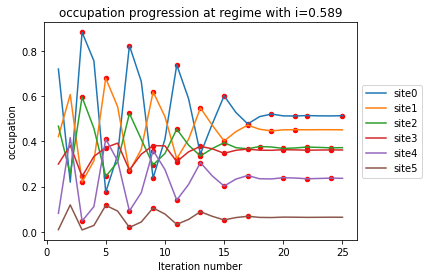

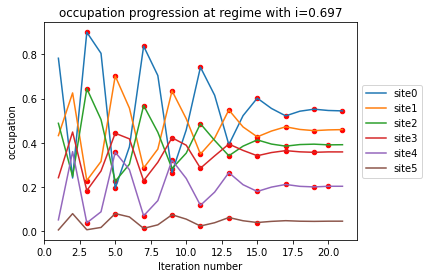

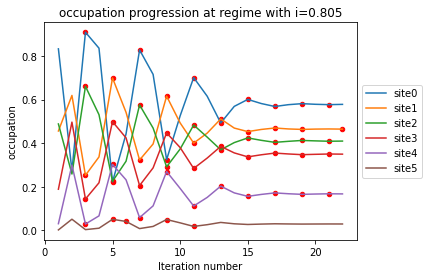

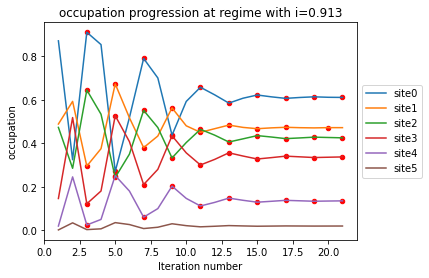

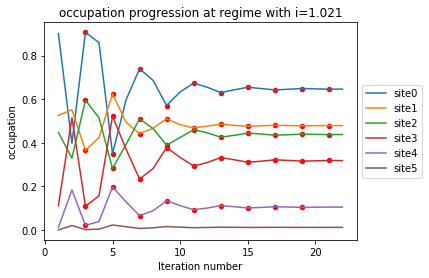

In [8]:
for x_i in range(10):
    fig, ax = plt.subplots(1,1,figsize=(7,4))
    norm = mpl.colors.Normalize(vmin=-0.05,  vmax=2.1)
    regime = np.array(y[x_i])
    v_ext = x[x_i]

    key_list = list()

    for site_id in range(6):
        length = len(regime)
        plt.plot(np.arange(len(regime))+1, regime[:,site_id], color=mpl.cm.tab10(site_id), label=f'site{site_id}')

    for key1 in  correction_dict_list[x_i].keys():
        iter_key, site_key = key1
        
        value = correction_dict_list[x_i][key1]
        plt.scatter([iter_key+1], [regime[iter_key,site_key]], c='r', s=20)


    plt.xlabel("Iteration number")
    plt.ylabel("occupation")
    plt.title(f'occupation progression at regime with i={v_ext:.3f}')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [9]:
delta_v = 0.5
num_iter = 21
for start_pot in np.linspace(start_hxc - delta_v, start_hxc + delta_v, num_iter-1):
    mol1.v_hxc[0] = num_iter
    mol1.self_consistent_loop(num_iter=30, tolerance=1E-6, oscillation_compensation=2)
    converged_densities.append(mol1.n_ks.copy())
    converged_hxc.append(mol1.v_hxc.copy())

NameError: name 'start_hxc' is not defined

In [37]:
converged_densities = np.array(converged_densities)
converged_hxc = np.array(converged_hxc)

Text(0.5, 0.98, 'Chain of 6 sites with U=3')

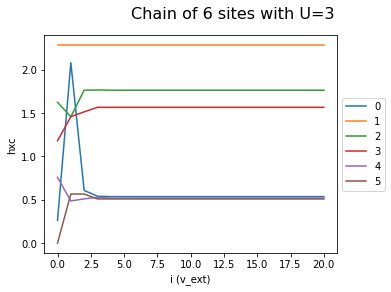

In [42]:
colors = plt.cm.viridis(np.linspace(0, num_iter, num_iter))
norm = mpl.colors.Normalize(vmin=0, vmax=num_iter)


fig, ax = plt.subplots(1,1, figsize=(7,4))

for i in range(6):
    plt.plot(range(num_iter), converged_hxc[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i))
plt.xlabel("i (v_ext)")
# plt.xlim(-.6, 2.1)
plt.ylabel("hxc")
# plt.ylim(0,1)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle(f'Chain of 6 sites with U={U_param}', fontsize=16)
# plt.savefig(f'results/Chain1_filtered/picture1_U-{U_param}.png', dpi=150)

In [50]:
print(converged_hxc)

[[0.26189861 2.28406014 1.62597228 1.18151375 0.7587325  0.        ]
 [2.08330406 2.28406014 1.45816706 1.45967923 0.48636807 0.56609918]
 [0.6077795  2.28406014 1.76526746 1.51545789 0.50994613 0.56609918]
 [0.54055513 2.28406014 1.76846869 1.56794231 0.52782106 0.50897012]
 [0.53632211 2.28406014 1.76537918 1.56794231 0.51870393 0.50897012]
 [0.53634276 2.28406014 1.76530666 1.56794231 0.51912916 0.50897012]
 [0.53625329 2.28406014 1.7652941  1.56794231 0.51910774 0.50897012]
 [0.53624977 2.28406014 1.76529347 1.56794231 0.5191083  0.50897012]
 [0.53625277 2.28406014 1.76529352 1.56794231 0.51910816 0.50897012]
 [0.53626011 2.28406014 1.76529351 1.56794231 0.51910826 0.50897012]
 [0.53625958 2.28406014 1.76529344 1.56794231 0.51910846 0.50897012]
 [0.5362593  2.28406014 1.76529335 1.56794231 0.51910842 0.50897012]
 [0.5362537  2.28406014 1.76529348 1.56794231 0.51910827 0.50897012]
 [0.53626145 2.28406014 1.76529338 1.56794231 0.51910831 0.50897012]
 [0.53626027 2.28406014 1.76529353

Text(0.5, 0.98, 'Chain of 6 sites with U=3')

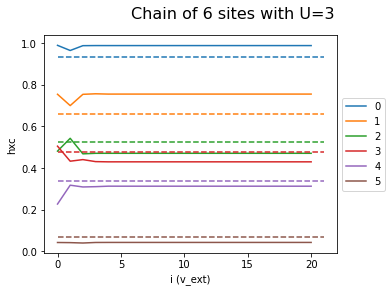

In [49]:
colors = plt.cm.viridis(np.linspace(0, num_iter, num_iter))
norm = mpl.colors.Normalize(vmin=0, vmax=num_iter)


fig, ax = plt.subplots(1,1, figsize=(7,4))

for i in range(6):
    plt.plot(range(num_iter), converged_densities[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i))
    plt.hlines(densities_ref[i], 0, num_iter, color=mpl.cm.get_cmap('tab10')(i), linestyle='--')
plt.xlabel("i (v_ext)")
# plt.xlim(-.6, 2.1)
plt.ylabel("hxc")
# plt.ylim(0,1)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle(f'Chain of 6 sites with U={U_param}', fontsize=16)
# plt.savefig(f'results/Chain1_filtered/picture1_U-{U_param}.png', dpi=150)

In [47]:
densities_ref = y_ab.diagonal()

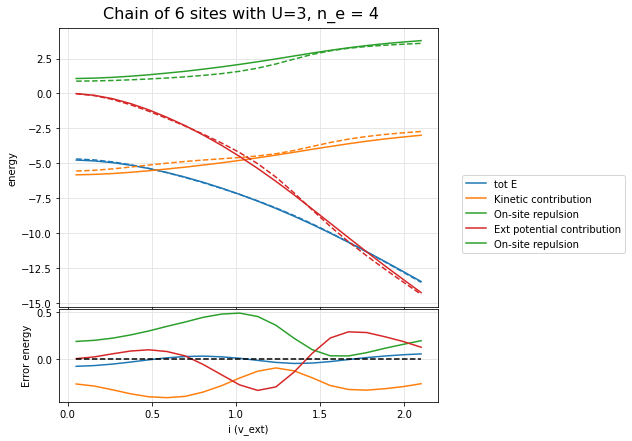

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout() 
fig.subplots_adjust(hspace=0.01, top=0.93)
ax[0].grid(True, color='#E2E2E2')
ax[1].grid(True, color='#E2E2E2')
ax[0].plot(x, E['tot'], c=mpl.cm.get_cmap('tab10')(0), label='tot E')
ax[0].plot(x, E_ref['tot'], c=mpl.cm.get_cmap('tab10')(0), linestyle='--')
ax[0].plot(x, E['kin'], c=mpl.cm.get_cmap('tab10')(1), label='Kinetic contribution')
ax[0].plot(x, E_ref['kin'], c=mpl.cm.get_cmap('tab10')(1), linestyle='--')
ax[0].plot(x, E['u'], c=mpl.cm.get_cmap('tab10')(2), label='On-site repulsion')
ax[0].plot(x, E_ref['u'], c=mpl.cm.get_cmap('tab10')(2), linestyle='--')
ax[0].plot(x, E['v_ext'], c=mpl.cm.get_cmap('tab10')(3), label='Ext potential contribution')
ax[0].plot(x, E_ref['v_ext'], c=mpl.cm.get_cmap('tab10')(3), linestyle='--')
plt.xlabel("i (v_ext)")
ax[0].set_ylabel('energy')
ax[1].set_ylabel('Error energy')
ax[1].plot(x, E['tot'] - E_ref['tot'], c=mpl.cm.get_cmap('tab10')(0))
ax[1].plot(x, E['kin'] - E_ref['kin'], c=mpl.cm.get_cmap('tab10')(1))
ax[1].plot(x, E['u'] - E_ref['u'], c=mpl.cm.get_cmap('tab10')(2), label='On-site repulsion')
ax[1].plot(x, E['v_ext'] - E_ref['v_ext'], c=mpl.cm.get_cmap('tab10')(3))
ax[1].plot(x, [0]*len(x), c='k', linestyle='--')
fig.suptitle(f'Chain of 6 sites with U={U_param}, n_e = {n_electron}', fontsize=16)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(f'results/Chain1_filtered/Energy_errors_ne-{n_electron}_0.1.png', dpi=150,  bbox_inches='tight')

Text(0.5, 0.98, 'Chain of 6 sites with U=3, n_e = 4')

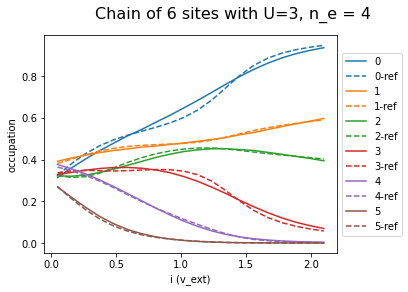

In [11]:

colors = plt.cm.viridis(np.linspace(0, max(x), len(x)))
norm = mpl.colors.Normalize(vmin=0, vmax=max(x))


fig, ax = plt.subplots(1,1, figsize=(7,4))

for i in range(6):
    plt.plot(x, y_simple[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i))
    plt.plot(x, y_ref[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i)+'-ref', linestyle='--')
plt.xlabel("i (v_ext)")
# plt.xlim(-.6, 2.1)
plt.ylabel("occupation")
# plt.ylim(0,1)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle(f'Chain of 6 sites with U={U_param}, n_e = {n_electron}', fontsize=16)
# plt.savefig(f'results/Chain1_filtered/Densities_ne-{n_electron}_0.1.png', dpi=150,  bbox_inches='tight')

3 1 (2.0518894623867636, 2.0518894623867636, 2.1530475661061175, 2.1530475661061175)
2 1 (2.1687435903377157, 4.278647752686587, 3.4050362487654873, 3.4050362487654873)
6 1 (3.4050362487654873, 3.4050362487654873, 3.3095312242960295, 3.3095312242960295)
2 1 (5.254109479377048, -0.5384290829029705, 0.19712521924309834, 0.19712521924309834)
3 1 (-0.5384290829029705, 0.19712521924309834, 1.4540606699615857, 1.4540606699615857)
4 1 (0.19712521924309834, 1.4540606699615857, 2.3652708145652896, 2.3652708145652896)
5 1 (1.4540606699615857, 2.3652708145652896, 3.0252074552778048, 3.0252074552778048)
2 1 (4.024540111422539, 2.1293803703022562, 2.869329590740164, 2.869329590740164)
3 1 (2.1293803703022562, 2.869329590740164, 3.552304233296544, 3.552304233296544)
2 1 (4.177371077239513, 4.177371077239513, 2.7693238112253478, 2.7693238112253478)
3 1 (4.177371077239513, 2.7693238112253478, 2.9450827759017844, 2.9450827759017844)
4 1 (2.7693238112253478, 2.9450827759017844, 3.389819514942604, 3.3898

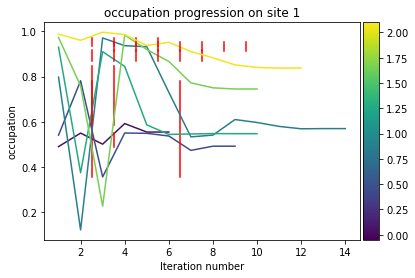

In [31]:
# Same site in the same picture

norm = mpl.colors.Normalize(vmin=-0.05,  vmax=2.1)
plot_index = 1
for x_i, regime in enumerate(y):
    v_ext = x[x_i]
    length = len(regime)
    plt.plot(np.arange(len(regime))+1, regime[:,plot_index], color=mpl.cm.viridis(norm(v_ext)))
    
    key_list = list(correction_dict_list[x_i].keys())
    plot_keys = [i for i in key_list if i[1] == plot_index]
    for iter_key, site_key in plot_keys:
        value = correction_dict_list[x_i][(iter_key, site_key)]
        print(iter_key, site_key, value)
        plt.plot([iter_key+0.5,iter_key+0.5], [regime[x_i,plot_index], regime[x_i+1,plot_index]], c='r')


plt.xlabel("Iteration number")
plt.ylabel("occupation")
plt.title(f'occupation progression on site {plot_index}')
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.viridis, orientation='vertical', norm=norm)
plt.gcf().add_axes(ax_cb)
plt.savefig(f'results/Chain1_U-5/occupation(iter)_oscillations_site-{plot_index}.png', dpi=150)

In [51]:
lpfet.COMPENSATION_1_RATIO = 0.25
x = np.arange(0.05, 2.1, 0.1)
# x = np.arange(0.01, 0.1, 0.005)
U_param = 3
n_electron = 6
n_sites = 6
name = 'chain1'
mol1 = lpfet.Molecule(n_sites, n_electron, name)
mol_full = lpfet.class_Quant_NBody.QuantNBody(n_sites, n_electron)
mol_full.build_operator_a_dagger_a()
y = []
y_simple = []
y_ref = []
energy_ref = []
energy = []
first = True
correction_dict_list = []
for i in x:
    first = False
    print(f'{i:.1f}, {i/max(x)*100:.1f}%: ', end=' ')
    pmv = i
    
    nodes_dict = dict()
    edges_dict = dict()
    eq_list = []
    for j in range(6):
        nodes_dict[j] = {'v': (j - 2.5) * i, 'U': U_param}
        if j != 5:
            edges_dict[(j, j+1)] = 1
        eq_list.append([j])
    t, v_ext, u = lpfet.generate_from_graph(nodes_dict, edges_dict)
    mol1.add_parameters(u, t, v_ext, eq_list)
    mol1.self_consistent_loop(num_iter=30, tolerance=1E-6, oscillation_compensation=2)
    # mol1.optimize_solution(5, 0.2)
    mol1.calculate_energy(True)
    correction_dict_list.append(mol1.oscillation_correction_dict)
    y.append(mol1.density_progress)
    y_simple.append(mol1.n_ks)
    y_ab, mol_fci, energy_ref_i =mol1.compare_densities_FCI(pass_object=mol_full)
    y_ref.append(y_ab.diagonal())
    
    energy.append(mol1.energy_contributions)
    energy_ref.append(energy_ref_i)

for i in range(len(y)):
    y[i] = np.array(y[i], dtype=float)
y_ref = np.array(y_ref)
y_simple = np.array(y_simple) 

E = np.array(energy, dtype=[('tot', float), ('kin', float), ('v_ext', float), ('u', float)])
E_ref = np.array(energy_ref, dtype=[('tot', float), ('kin', float), ('v_ext', float), ('u', float)])


	 ====  The matrix form of a^a is built  ====

	 ====  The matrix form of a^a is built  ====
0.1, 2.4%:  Loop 0, Loop 1, Loop 2, Loop 3, FCI densities (per spin): [0.50501795 0.49982059 0.50250144 0.49749856 0.50017941 0.49498205]
Eigenvalue energy: -3.717416947976853, calculated from contributions: -3.717416947976853
0.2, 7.3%:  Loop 0, Loop 1, Loop 2, FCI densities (per spin): [0.51552613 0.49967235 0.50768025 0.49231975 0.50032765 0.48447387]
Eigenvalue energy: -3.728445818568536, calculated from contributions: -3.728445818568536
0.3, 12.2%:  Loop 0, Loop 1, Loop 2, FCI densities (per spin): [0.52773038 0.50027813 0.51344029 0.48655971 0.49972187 0.47226962]
Eigenvalue energy: -3.7518883280716757, calculated from contributions: -3.7518883280716757
0.4, 17.1%:  Loop 0, Loop 1, Loop 2, FCI densities (per spin): [0.54402522 0.50268409 0.52036327 0.47963673 0.49731591 0.45597478]
Eigenvalue energy: -3.7913738395181515, calculated from contributions: -3.7913738395181515
0.5, 22.0%:  Loo

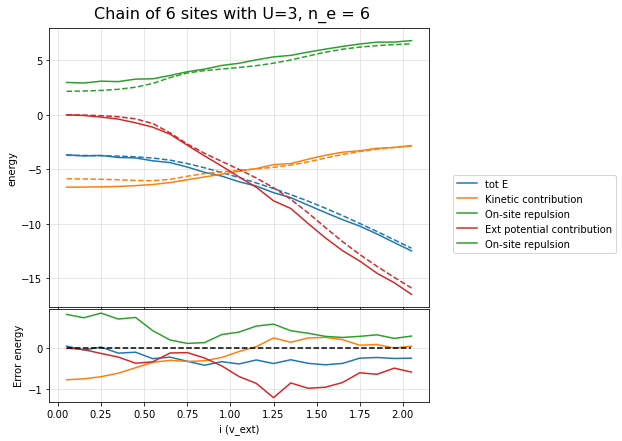

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout() 
fig.subplots_adjust(hspace=0.01, top=0.93)
ax[0].grid(True, color='#E2E2E2')
ax[1].grid(True, color='#E2E2E2')
ax[0].plot(x, E['tot'], c=mpl.cm.get_cmap('tab10')(0), label='tot E')
ax[0].plot(x, E_ref['tot'], c=mpl.cm.get_cmap('tab10')(0), linestyle='--')
ax[0].plot(x, E['kin'], c=mpl.cm.get_cmap('tab10')(1), label='Kinetic contribution')
ax[0].plot(x, E_ref['kin'], c=mpl.cm.get_cmap('tab10')(1), linestyle='--')
ax[0].plot(x, E['u'], c=mpl.cm.get_cmap('tab10')(2), label='On-site repulsion')
ax[0].plot(x, E_ref['u'], c=mpl.cm.get_cmap('tab10')(2), linestyle='--')
ax[0].plot(x, E['v_ext'], c=mpl.cm.get_cmap('tab10')(3), label='Ext potential contribution')
ax[0].plot(x, E_ref['v_ext'], c=mpl.cm.get_cmap('tab10')(3), linestyle='--')
plt.xlabel("i (v_ext)")
ax[0].set_ylabel('energy')
ax[1].set_ylabel('Error energy')
ax[1].plot(x, E['tot'] - E_ref['tot'], c=mpl.cm.get_cmap('tab10')(0))
ax[1].plot(x, E['kin'] - E_ref['kin'], c=mpl.cm.get_cmap('tab10')(1))
ax[1].plot(x, E['u'] - E_ref['u'], c=mpl.cm.get_cmap('tab10')(2), label='On-site repulsion')
ax[1].plot(x, E['v_ext'] - E_ref['v_ext'], c=mpl.cm.get_cmap('tab10')(3))
ax[1].plot(x, [0]*len(x), c='k', linestyle='--')
fig.suptitle(f'Chain of 6 sites with U={U_param}, n_e = {n_electron}', fontsize=16)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(f'results/Chain1_filtered/Energy_errors_ne-{n_electron}_0.1.png', dpi=150,  bbox_inches='tight')

Text(0.5, 0.98, 'Chain of 6 sites with U=3, n_e = 6')

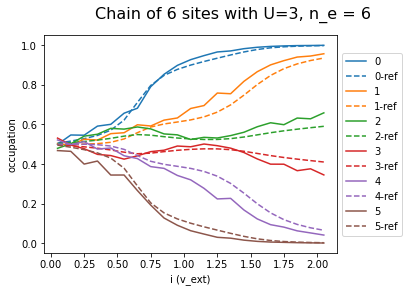

In [52]:

colors = plt.cm.viridis(np.linspace(0, max(x), len(x)))
norm = mpl.colors.Normalize(vmin=0, vmax=max(x))


fig, ax = plt.subplots(1,1, figsize=(7,4))

for i in range(6):
    plt.plot(x, y_simple[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i))
    plt.plot(x, y_ref[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i)+'-ref', linestyle='--')
plt.xlabel("i (v_ext)")
# plt.xlim(-.6, 2.1)
plt.ylabel("occupation")
# plt.ylim(0,1)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle(f'Chain of 6 sites with U={U_param}, n_e = {n_electron}', fontsize=16)
# plt.savefig(f'results/Chain1_filtered/Densities_ne-{n_electron}_0.1.png', dpi=150,  bbox_inches='tight')

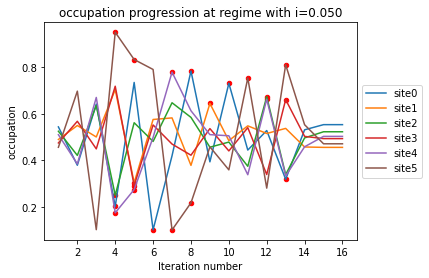

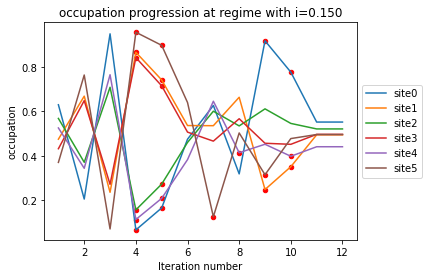

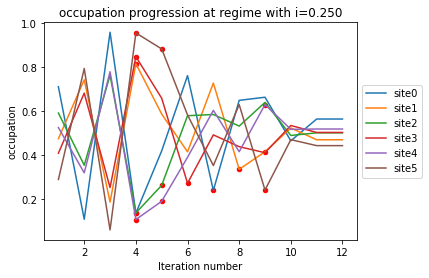

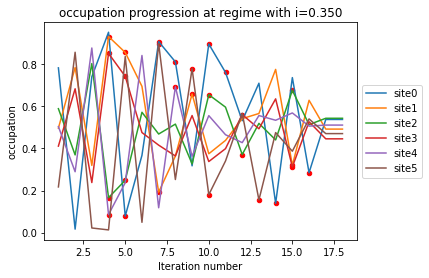

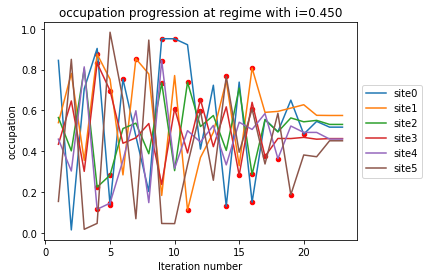

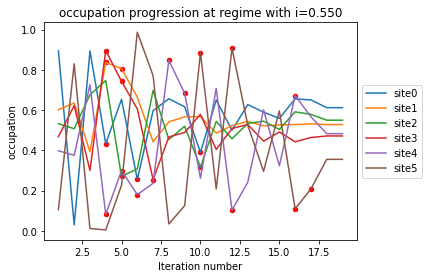

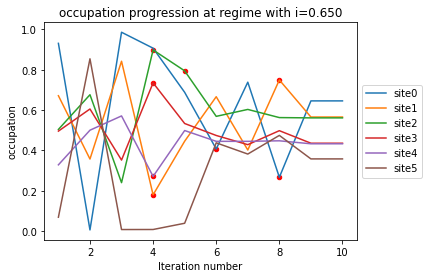

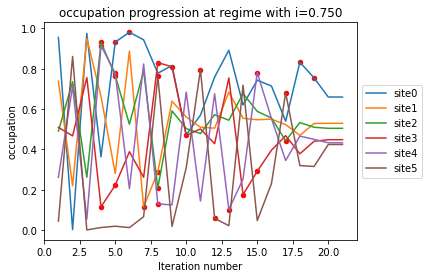

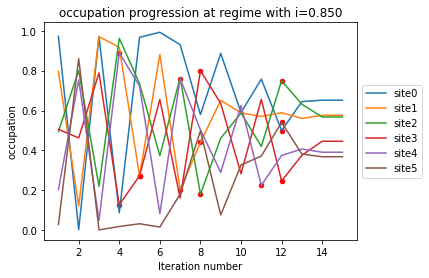

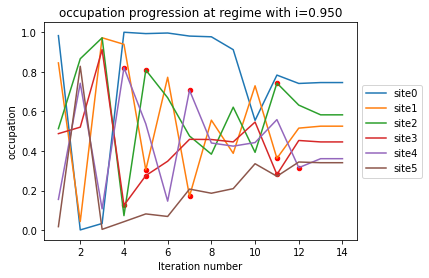

In [73]:
# one regime per picture
for x_i in range(10):
    fig, ax = plt.subplots(1,1,figsize=(7,4))
    norm = mpl.colors.Normalize(vmin=-0.05,  vmax=2.1)
    regime = y[x_i]
    v_ext = x[x_i]

    key_list = list()

    for site_id in range(6):
        length = len(regime)
        plt.plot(np.arange(len(regime))+1, regime[:,site_id], color=mpl.cm.tab10(site_id), label=f'site{site_id}')

    for key1 in  correction_dict_list[x_i].keys():
        iter_key, site_key = key1
        
        value = correction_dict_list[x_i][key1]
        plt.scatter([iter_key+1], [regime[iter_key,site_key]], c='r', s=20)


    plt.xlabel("Iteration number")
    plt.ylabel("occupation")
    plt.title(f'occupation progression at regime with i={v_ext:.3f}')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f'results/Chain1_U-5/occupation(iter)_oscillations_regime-i-{v_ext:.3f}.png', dpi=150)


## Many random starting configurations
Random values from -0.05 to 0.05

In [118]:
experiment_number = 60

In [119]:
lpfet.COMPENSATION_1_RATIO = 0.5
i = 0.5
name = 'chain2'
mol1 = lpfet.Molecule(6,6, name)
mol_full = lpfet.class_Quant_NBody.QuantNBody(6, 6)
mol_full.build_operator_a_dagger_a()
y = []
y_simple = []
y_ref = []
first = True
inp_values = []
nodes_dict = dict()
edges_dict = dict()
eq_list = []
for j in range(6):
    nodes_dict[j] = {'v': (j - 2.5) * i, 'U': 5}
    if j != 5:
        edges_dict[(j, j+1)] = 1
    eq_list.append([j])

for temp_var in range(experiment_number):
    if not first:
        mol1.clear_object(name)
    first = False
    print('\n',f'{temp_var/experiment_number*100:.1f}%', end=': ')
    t, v_ext, u = lpfet.generate_from_graph(nodes_dict, edges_dict)
    mol1.add_parameters(u, t, v_ext, eq_list)
    initial_v_hxc = np.random.random(6) * 0.1 - 0.05
    mol1.v_hxc = initial_v_hxc
    inp_values.append(initial_v_hxc)
    mol1.self_consistent_loop(num_iter=30, tolerance=1e-6, oscillation_compensation=1)
    y.append(mol1.density_progress)
    y_simple.append(mol1.n_ks)

y_ab, rest =mol1.compare_densities_FCI(pass_object=mol_full)
y_ab /= 2
y_ref = y_ab.diagonal()

for i in range(len(y)):
    y[i] = np.array(y[i], dtype=float)
y_ref = np.array(y_ref)
y_simple = np.array(y_simple) 


	 ====  The matrix form of a^a is built  ====

	 ====  The matrix form of a^a is built  ====

 0.0%: Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, 
 1.7%: Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, 
 3.3%: Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, 
 5.0%: Loop 0, Loop 1, Loop 2, -0.32->-0.55->-0.40!=-0.24, Loop 3, Loop 4, Loop 5, 
 6.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 8.3%: Loop 0, Loop 1, Loop 2, Loop 3, 
 10.0%: Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, 
 11.7%: Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, 
 13.3%: Loop 0, Loop 1, Loop 2, -0.28->-0.54->-0.42!=-0.31, Loop 3, Loop 4, Loop 5, 
 15.0%: Loop 0, Loop 1, Loop 2, -0.26->-0.63->-0.41!=-0.19, Loop 3, Loop 4, Loop 5, 
 16.7%: Loop 0, Loop 1, -0.61->-0.36->-0.56!=-0.77, -0.41->-0.66->-0.49!=-0.31, Loop 2, Loop 3, Loop 4, Loop 5, 
 18.3%: Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, 
 20.0%: Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, 
 21.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 23.3%: Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, Loop 5, 
 25.0%: Loop 0, Loop

index 0: my result: 0.833, reference: 0.802; difference: 0.031, stdev: 0.009
index 1: my result: 0.540, reference: 0.548; difference: -0.008, stdev: 0.010
index 2: my result: 0.565, reference: 0.564; difference: 0.001, stdev: 0.009
index 3: my result: 0.443, reference: 0.436; difference: 0.008, stdev: 0.009
index 4: my result: 0.455, reference: 0.452; difference: 0.003, stdev: 0.007
index 5: my result: 0.164, reference: 0.198; difference: -0.034, stdev: 0.014


Text(0.5, 1.0, 'Density fluctuations with starting random v^Hxc between -0.05 and 0.05')

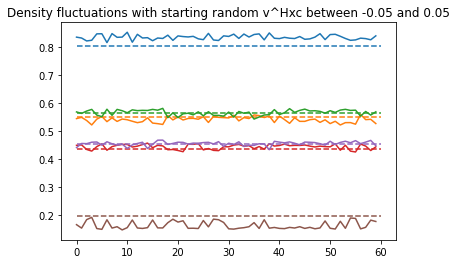

In [120]:

colors = mpl.cm.get_cmap('tab10')(5)

for i in range(6):
    plt.plot(y_simple[:,i], c=mpl.cm.get_cmap('tab10')(i))
    plt.hlines(y_ref[i], 0, experiment_number, color=mpl.cm.get_cmap('tab10')(i), linestyle='dashed')
    print(f'index {i}: my result: {np.average(y_simple[:,i]):.3f}, reference: {y_ref[i]:.3f}; difference: {np.average(y_simple[:,i])-y_ref[i]:.3f}, stdev: {np.std(y_simple[:,i]-y_ref[i]):.3f}')
plt.title('Density fluctuations with starting random v^Hxc between -0.05 and 0.05')

index 0: my result: 0.833, reference: 0.802; difference: 0.031, stdev: 0.009
index 1: my result: 0.540, reference: 0.548; difference: -0.008, stdev: 0.010
index 2: my result: 0.565, reference: 0.564; difference: 0.001, stdev: 0.009
index 3: my result: 0.443, reference: 0.436; difference: 0.008, stdev: 0.009
index 4: my result: 0.455, reference: 0.452; difference: 0.003, stdev: 0.007
index 5: my result: 0.164, reference: 0.198; difference: -0.034, stdev: 0.014


[(0.833279053730405,
  0.8024589129324315,
  0.03082014079797346,
  0.008797238083185947),
 (0.5396969379294876,
  0.5479496427957445,
  -0.008252704866256955,
  0.009802394649207766),
 (0.5652523491540742,
  0.5642716960686258,
  0.0009806530854483686,
  0.009420777833378623),
 (0.44327451836363935,
  0.4357283039313763,
  0.007546214432263054,
  0.008532324056456892),
 (0.4549360457820628,
  0.45205035720425757,
  0.0028856885778052455,
  0.007109482374282163),
 (0.1635610950403307,
  0.19754108706757023,
  -0.03397999202723953,
  0.013742324734577848)]

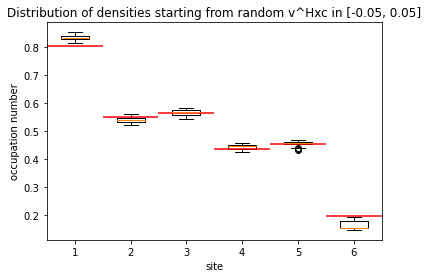

In [121]:
distribution_array_005 = []
plt.boxplot(y_simple)
for i in range(6):
    plt.hlines(y_ref[i], i+0.5, i+1.5, color='r')
    print(f'index {i}: my result: {np.average(y_simple[:,i]):.3f}, reference: {y_ref[i]:.3f}; difference: {np.average(y_simple[:,i])-y_ref[i]:.3f}, stdev: {np.std(y_simple[:,i]-y_ref[i]):.3f}')
    distribution_array_005.append((np.average(y_simple[:,i]), y_ref[i], np.average(y_simple[:,i])-y_ref[i], np.std(y_simple[:,i]-y_ref[i])))
plt.xlabel('site')
plt.ylabel('occupation number')
plt.title('Distribution of densities starting from random v^Hxc in [-0.05, 0.05]')
plt.savefig('results/Chain1/Distribution-densities_delta-0.05.png', dpi=150)
distribution_array_005

In [122]:
from sklearn.preprocessing import StandardScaler
pca_y = StandardScaler().fit_transform(y_simple) # normalizing the features

from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
principalComponents_pca_y = pca_model.fit_transform(pca_y)

[0.44222498 0.30140689]


Text(0.5, 1.0, 'PCA with starting configurations [-0.05, 0.05]')

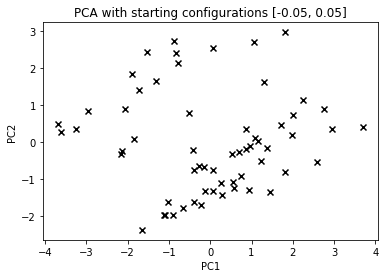

In [125]:
plt.scatter(principalComponents_pca_y[:,0], principalComponents_pca_y[:, 1], c='k', marker='x')
print(pca_model.explained_variance_ratio_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with starting configurations [-0.05, 0.05]')

In [126]:
lpfet.COMPENSATION_1_RATIO = 0.5
i = 0.5
name = 'chain2'
mol1 = lpfet.Molecule(6,6, name)
mol_full = lpfet.class_Quant_NBody.QuantNBody(6, 6)
mol_full.build_operator_a_dagger_a()
y = []
y_simple = []
y_ref = []
first = True
inp_values = []
nodes_dict = dict()
edges_dict = dict()
eq_list = []
for j in range(6):
    nodes_dict[j] = {'v': (j - 2.5) * i, 'U': 5}
    if j != 5:
        edges_dict[(j, j+1)] = 1
    eq_list.append([j])

for temp_var in range(experiment_number):
    if not first:
        mol1.clear_object(name)
    first = False
    print('\n',f'{temp_var/experiment_number*100:.1f}%', end=': ')
    t, v_ext, u = lpfet.generate_from_graph(nodes_dict, edges_dict)
    mol1.add_parameters(u, t, v_ext, eq_list)
    initial_v_hxc = np.random.random(6) * 0.01 - 0.005
    mol1.v_hxc = initial_v_hxc
    inp_values.append(initial_v_hxc)
    mol1.self_consistent_loop(num_iter=30, tolerance=1e-6, oscillation_compensation=1)
    y.append(mol1.density_progress)
    y_simple.append(mol1.n_ks)

y_ab, rest =mol1.compare_densities_FCI(pass_object=mol_full)
y_ab /= 2
y_ref = y_ab.diagonal()

for i in range(len(y)):
    y[i] = np.array(y[i], dtype=float)
y_ref = np.array(y_ref)
y_simple = np.array(y_simple) 


	 ====  The matrix form of a^a is built  ====

	 ====  The matrix form of a^a is built  ====

 0.0%: Loop 0, Loop 1, Loop 2, Loop 3, 
 1.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 3.3%: Loop 0, Loop 1, Loop 2, Loop 3, 
 5.0%: Loop 0, Loop 1, Loop 2, Loop 3, 
 6.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 8.3%: Loop 0, Loop 1, Loop 2, Loop 3, 
 10.0%: Loop 0, Loop 1, Loop 2, Loop 3, 
 11.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 13.3%: Loop 0, Loop 1, Loop 2, Loop 3, 
 15.0%: Loop 0, Loop 1, Loop 2, Loop 3, 
 16.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 18.3%: Loop 0, Loop 1, Loop 2, Loop 3, 
 20.0%: Loop 0, Loop 1, Loop 2, Loop 3, 
 21.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 23.3%: Loop 0, Loop 1, Loop 2, Loop 3, 
 25.0%: Loop 0, Loop 1, Loop 2, Loop 3, 
 26.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 28.3%: Loop 0, Loop 1, Loop 2, Loop 3, 
 30.0%: Loop 0, Loop 1, Loop 2, Loop 3, 
 31.7%: Loop 0, Loop 1, Loop 2, Loop 3, 
 33.3%: Loop 0, Loop 1, Loop 2, Loop 3, 
 35.0%: Loop 0, Loop 1, Loop 2, Loop 3, 
 36.7%: L

index 0: my result: 0.828, reference: 0.802; difference: 0.025
index 1: my result: 0.538, reference: 0.548; difference: -0.010
index 2: my result: 0.570, reference: 0.564; difference: 0.006
index 3: my result: 0.446, reference: 0.436; difference: 0.010
index 4: my result: 0.465, reference: 0.452; difference: 0.012
index 5: my result: 0.153, reference: 0.198; difference: -0.044


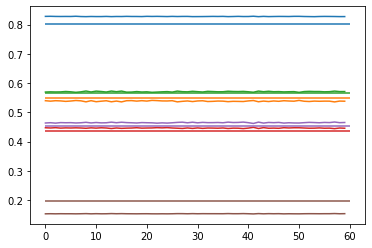

In [127]:
from matplotlib import cm
colors = cm.get_cmap('tab10')(5)

for i in range(6):
    plt.plot(y_simple[:,i], c=cm.get_cmap('tab10')(i))
    plt.hlines(y_ref[i], 0, experiment_number, color=cm.get_cmap('tab10')(i))
    print(f'index {i}: my result: {np.average(y_simple[:,i]):.3f}, reference: {y_ref[i]:.3f}; difference: {np.average(y_simple[:,i])-y_ref[i]:.3f}')

In [45]:
lpfet.COMPENSATION_1_RATIO = 0.25
x = np.arange(0.05, 2.1, 0.1)
# x = np.arange(0.01, 0.1, 0.005)
U_param = 3
n_electron = 6
n_sites = 6
name = 'chain1'
mol1 = lpfet.Molecule(n_sites, n_electron, name)
mol_full = lpfet.class_Quant_NBody.QuantNBody(n_sites, n_electron)
mol_full.build_operator_a_dagger_a()
y = []
y_simple = []
y_ref = []
energy_ref = []
energy = []
first = True
correction_dict_list = []
for i in x:
    if not first:
        mol1.clear_object(name)
    first = False
    print(f'{i:.1f}, {i/max(x)*100:.1f}%: ', end=' ')
    pmv = i
    
    nodes_dict = dict()
    edges_dict = dict()
    eq_list = []
    for j in range(6):
        nodes_dict[j] = {'v': (j - 2.5) * i, 'U': U_param}
        if j != 5:
            edges_dict[(j, j+1)] = 1
        eq_list.append([j])
    t, v_ext, u = lpfet.generate_from_graph(nodes_dict, edges_dict)
    mol1.add_parameters(u, t, v_ext, eq_list)
    mol1.self_consistent_loop(num_iter=30, tolerance=1E-6, oscillation_compensation=2)
    # mol1.optimize_solution(5, 0.2)
    mol1.calculate_energy(True)
    correction_dict_list.append(mol1.oscillation_correction_dict)
    y.append(mol1.density_progress)
    y_simple.append(mol1.n_ks)
    y_ab, mol_fci, energy_ref_i =mol1.compare_densities_FCI(pass_object=mol_full)
    y_ref.append(y_ab.diagonal())
    
    energy.append(mol1.energy_contributions)
    energy_ref.append(energy_ref_i)

for i in range(len(y)):
    y[i] = np.array(y[i], dtype=float)
y_ref = np.array(y_ref)
y_simple = np.array(y_simple) 

E = np.array(energy, dtype=[('tot', float), ('kin', float), ('v_ext', float), ('u', float)])
E_ref = np.array(energy_ref, dtype=[('tot', float), ('kin', float), ('v_ext', float), ('u', float)])


	 ====  The matrix form of a^a is built  ====

	 ====  The matrix form of a^a is built  ====
0.1, 2.4%:  Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, Loop 5, Loop 6, Loop 7, Loop 8, Loop 9, FCI densities (per spin): [0.93607233 0.82499759 0.7852764  0.77908171 0.77915648 0.89541549]
Eigenvalue energy: 8.71683749906169, calculated from contributions: 8.71683749906169
0.2, 7.3%:  Loop 0, Loop 1, Loop 2, Loop 3, Loop 4, Loop 5, Loop 6, Loop 7, Loop 8, FCI densities (per spin): [0.96524733 0.87552987 0.79830387 0.77102257 0.74392087 0.84597549]
Eigenvalue energy: 8.648183329341549, calculated from contributions: 8.648183329341549
0.3, 12.2%:  Loop 0, Loop 1, Loop 2, Loop 3, FCI densities (per spin): [0.98304632 0.92044952 0.82412533 0.76141978 0.71851226 0.79244679]
Eigenvalue energy: 8.51543900106695, calculated from contributions: 8.51543900106695
0.4, 17.1%:  Loop 0, Loop 1, Loop 2, 2.45->2.14->2.22!=2.45, Loop 3, Loop 4, Loop 5, Loop 6, FCI densities (per spin): [0.99230704 0.95298256 0.85

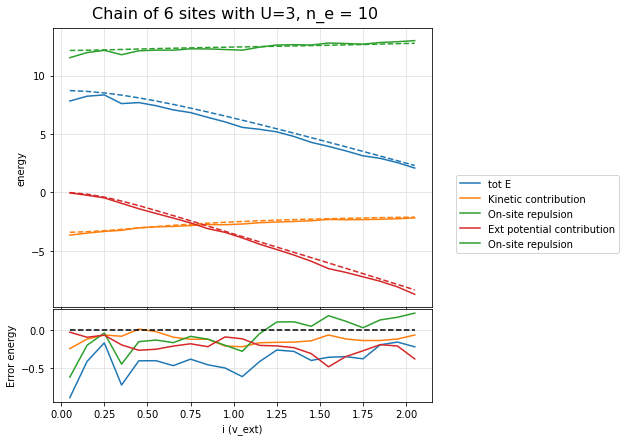

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout() 
fig.subplots_adjust(hspace=0.01, top=0.93)
ax[0].grid(True, color='#E2E2E2')
ax[1].grid(True, color='#E2E2E2')
ax[0].plot(x, E['tot'], c=mpl.cm.get_cmap('tab10')(0), label='tot E')
ax[0].plot(x, E_ref['tot'], c=mpl.cm.get_cmap('tab10')(0), linestyle='--')
ax[0].plot(x, E['kin'], c=mpl.cm.get_cmap('tab10')(1), label='Kinetic contribution')
ax[0].plot(x, E_ref['kin'], c=mpl.cm.get_cmap('tab10')(1), linestyle='--')
ax[0].plot(x, E['u'], c=mpl.cm.get_cmap('tab10')(2), label='On-site repulsion')
ax[0].plot(x, E_ref['u'], c=mpl.cm.get_cmap('tab10')(2), linestyle='--')
ax[0].plot(x, E['v_ext'], c=mpl.cm.get_cmap('tab10')(3), label='Ext potential contribution')
ax[0].plot(x, E_ref['v_ext'], c=mpl.cm.get_cmap('tab10')(3), linestyle='--')
plt.xlabel("i (v_ext)")
ax[0].set_ylabel('energy')
ax[1].set_ylabel('Error energy')
ax[1].plot(x, E['tot'] - E_ref['tot'], c=mpl.cm.get_cmap('tab10')(0))
ax[1].plot(x, E['kin'] - E_ref['kin'], c=mpl.cm.get_cmap('tab10')(1))
ax[1].plot(x, E['u'] - E_ref['u'], c=mpl.cm.get_cmap('tab10')(2), label='On-site repulsion')
ax[1].plot(x, E['v_ext'] - E_ref['v_ext'], c=mpl.cm.get_cmap('tab10')(3))
ax[1].plot(x, [0]*len(x), c='k', linestyle='--')
fig.suptitle(f'Chain of 6 sites with U={U_param}, n_e = {n_electron}', fontsize=16)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(f'results/Chain1_filtered/Energy_errors_ne-{n_electron}_0.1.png', dpi=150,  bbox_inches='tight')

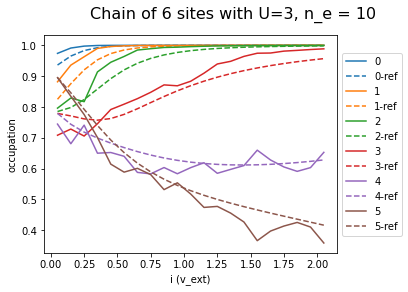

In [47]:

colors = plt.cm.viridis(np.linspace(0, max(x), len(x)))
norm = mpl.colors.Normalize(vmin=0, vmax=max(x))


fig, ax = plt.subplots(1,1, figsize=(7,4))

for i in range(6):
    plt.plot(x, y_simple[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i))
    plt.plot(x, y_ref[:, i], c=mpl.cm.get_cmap('tab10')(i), label=str(i)+'-ref', linestyle='--')
plt.xlabel("i (v_ext)")
# plt.xlim(-.6, 2.1)
plt.ylabel("occupation")
# plt.ylim(0,1)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle(f'Chain of 6 sites with U={U_param}, n_e = {n_electron}', fontsize=16)
# plt.savefig(f'results/Chain1_filtered/Densities_ne-{n_electron}_0.1.png', dpi=150,  bbox_inches='tight')

index 0: my result: 0.828, reference: 0.802; difference: 0.025, stdev: 0.000
index 1: my result: 0.538, reference: 0.548; difference: -0.010, stdev: 0.001
index 2: my result: 0.570, reference: 0.564; difference: 0.006, stdev: 0.001
index 3: my result: 0.446, reference: 0.436; difference: 0.010, stdev: 0.001
index 4: my result: 0.465, reference: 0.452; difference: 0.012, stdev: 0.001
index 5: my result: 0.153, reference: 0.198; difference: -0.044, stdev: 0.000


[(0.8276546488596443,
  0.8024589129324315,
  0.025195735927212803,
  0.00033048536114638265),
 (0.5381800649171872,
  0.5479496427957445,
  -0.009769577878557367,
  0.0013379295228897663),
 (0.5704699774036754,
  0.5642716960686258,
  0.006198281335049627,
  0.0011501067135211043),
 (0.4460830120329328,
  0.4357283039313763,
  0.010354708101556531,
  0.0008878072643542853),
 (0.4645463623761817,
  0.45205035720425757,
  0.012496005171924118,
  0.0010256944882945079),
 (0.15306593441037855,
  0.19754108706757023,
  -0.04447515265719168,
  0.0002604042993252579)]

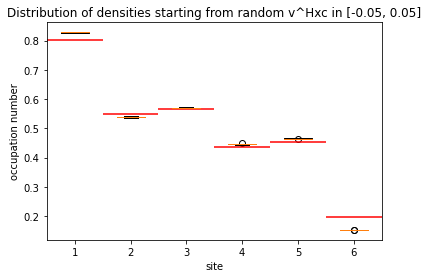

In [128]:
distribution_array_0005 = []
plt.boxplot(y_simple)
for i in range(6):
    plt.hlines(y_ref[i], i+0.5, i+1.5, color='r')
    print(f'index {i}: my result: {np.average(y_simple[:,i]):.3f}, reference: {y_ref[i]:.3f}; difference: {np.average(y_simple[:,i])-y_ref[i]:.3f}, stdev: {np.std(y_simple[:,i]-y_ref[i]):.3f}')
    distribution_array_0005.append((np.average(y_simple[:,i]), y_ref[i], np.average(y_simple[:,i])-y_ref[i], np.std(y_simple[:,i]-y_ref[i])))
plt.xlabel('site')
plt.ylabel('occupation number')
plt.title('Distribution of densities starting from random v^Hxc in [-0.05, 0.05]')
plt.savefig('results/Chain1/Distribution-densities_delta-0.005.png', dpi=150)
distribution_array_0005

In [129]:
distribution_array_0005 = np.array(distribution_array_0005)
distribution_array_005 = np.array(distribution_array_005)

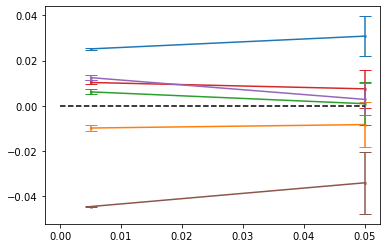

In [130]:
for i in range(6):
    plt.plot([0.005, 0.05], [distribution_array_0005[i, 2], distribution_array_005[i, 2]], c=mpl.cm.get_cmap('tab10')(i))
    plt.errorbar([0.005, 0.05], [distribution_array_0005[i, 2], distribution_array_005[i, 2]], [distribution_array_0005[i, 3], distribution_array_005[i, 3]], c=mpl.cm.get_cmap('tab10')(i), fmt='x', markersize=2, capsize=6)
plt.hlines(0, 0, 0.05, color='k', linestyle='dashed')

In [132]:

nodes_dict = {0:{'v': -2, 'U': 5}, 1:{'v': -4, 'U': 5}, 2:{'v': -2, 'U': 5}}
edges_dict = {(0,1):1, (1,2):1}
t, v_ext, u = lpfet.generate_from_graph(nodes_dict, edges_dict)
essentials.print_matrix(t)

  +0.000   -1.000   +0.000
  -1.000   +0.000   -1.000
  +0.000   -1.000   +0.000
